# Benchmarking Classical vs Genetic Neural Networks

This notebook benchmarks classical feed-forward fully connected neural networks against networks using GeneticLayer on several classification datasets from scikit-learn, including complex ones like Olivetti faces and forest cover types.

## 1. Setup

In [1]:
%load_ext autoreload
%autoreload 2

### 1.1 Imports

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
from sklearn.datasets import (
    fetch_covtype,
    fetch_olivetti_faces,
    load_breast_cancer,
    load_digits,
    load_iris,
    load_wine,
    make_classification,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from examples.utils.network_factory import (
    create_classical_network,
    create_genetic_network,
)
from examples.utils.trainer_utils import train_and_evaluate

logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)

### 1.2 Data Loading and Preprocessing

In [3]:
# Load and preprocess datasets
datasets = {
    "digits": load_digits(),
    "iris": load_iris(),
    "wine": load_wine(),
    "breast_cancer": load_breast_cancer(),
    "synthetic": make_classification(
        n_samples=1500,
        n_features=50,
        n_informative=30,
        n_redundant=10,
        n_classes=7,
        random_state=42,
    ),
    "covtype": fetch_covtype(),
    "olivetti": fetch_olivetti_faces(),
}

processed_datasets = {}
for name, data in datasets.items():
    if isinstance(data, tuple):  # For synthetic dataset
        X, y = data
    else:
        X, y = data.data, data.target
    if name == "covtype":
        # Subsample to 10k samples for manageability
        X, y = X[:10000], y[:10000]
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)
    train_loader = DataLoader(
        train_ds, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True
    )
    test_loader = DataLoader(
        test_ds, batch_size=32, num_workers=4, persistent_workers=True
    )
    processed_datasets[name] = {
        "input_size": X.shape[1],
        "output_size": len(np.unique(y)),
        "train_loader": train_loader,
        "val_loader": test_loader,
    }

## 2. Model Configuration

In [4]:
# Define depths for each architecture
classical_depths = [2, 4, 6]
genetic_heads = [1, 2, 3]
max_epochs = 32
results = {}

## 3. Training

In [5]:
# Train networks for each dataset, depth, and architecture
pbar_datasets = tqdm(total=len(processed_datasets), desc="Datasets")
pbar_classical = tqdm(total=len(processed_datasets) * len(classical_depths), desc="Classical")
pbar_genetic = tqdm(total=len(processed_datasets) * len(genetic_heads), desc="Genetic")

for dataset_name, data in processed_datasets.items():
    input_size = data["input_size"]
    output_size = data["output_size"]
    train_loader = data["train_loader"]
    val_loader = data["val_loader"]

    for depth in classical_depths:
        # Classical network
        classical_model = create_classical_network(input_size, depth, output_size)
        classical_metrics = train_and_evaluate(
            classical_model, train_loader, val_loader, max_epochs=max_epochs
        )
        results[f"{dataset_name}_classical_{depth}"] = classical_metrics
        pbar_classical.update(1)

    for n_heads in genetic_heads:
        # Genetic network
        genetic_model = create_genetic_network(input_size, n_heads, output_size)
        genetic_metrics = train_and_evaluate(
            genetic_model, train_loader, val_loader, max_epochs=max_epochs
        )
        results[f"{dataset_name}_genetic_{n_heads}"] = genetic_metrics
        pbar_genetic.update(1)

    pbar_datasets.update(1)

pbar_datasets.close()
pbar_classical.close()
pbar_genetic.close()

Datasets:   0%|          | 0/7 [00:00<?, ?it/s]

Classical:   0%|          | 0/21 [00:00<?, ?it/s]

Genetic:   0%|          | 0/21 [00:00<?, ?it/s]

## 4. Results

## Plotting

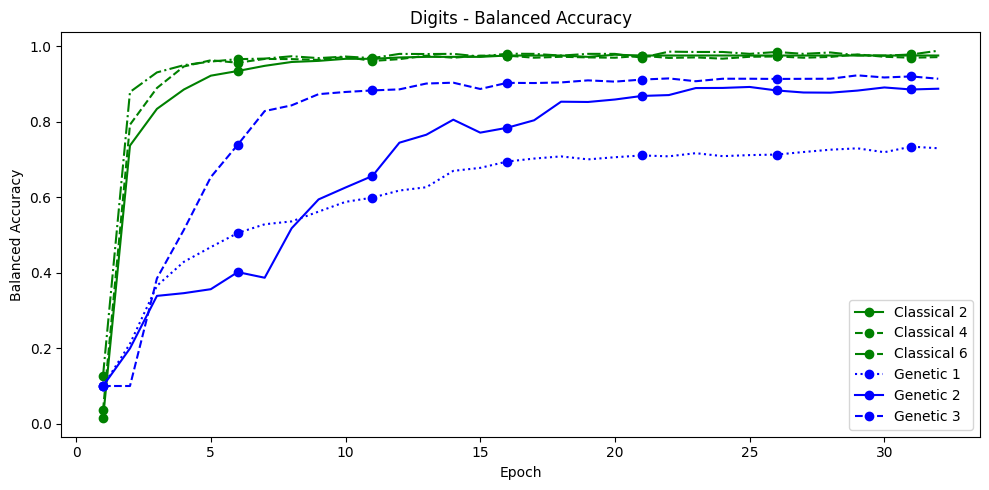

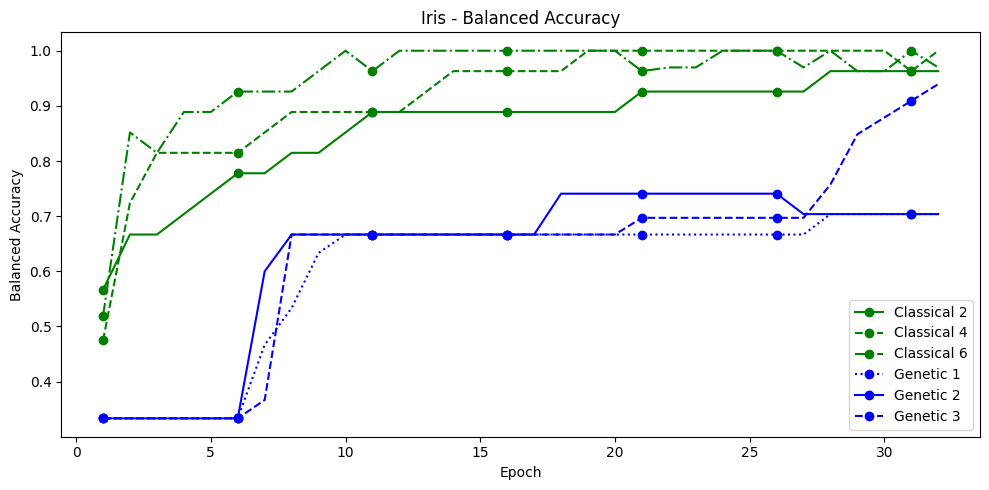

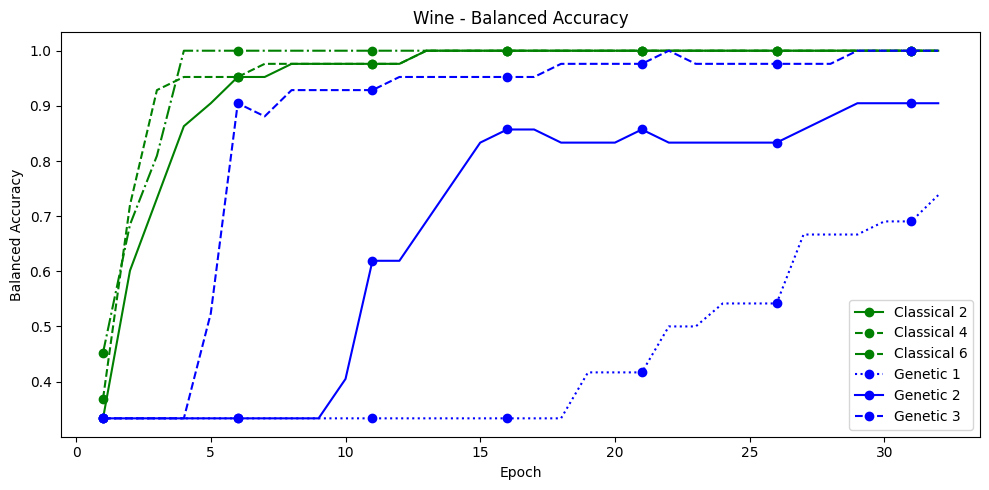

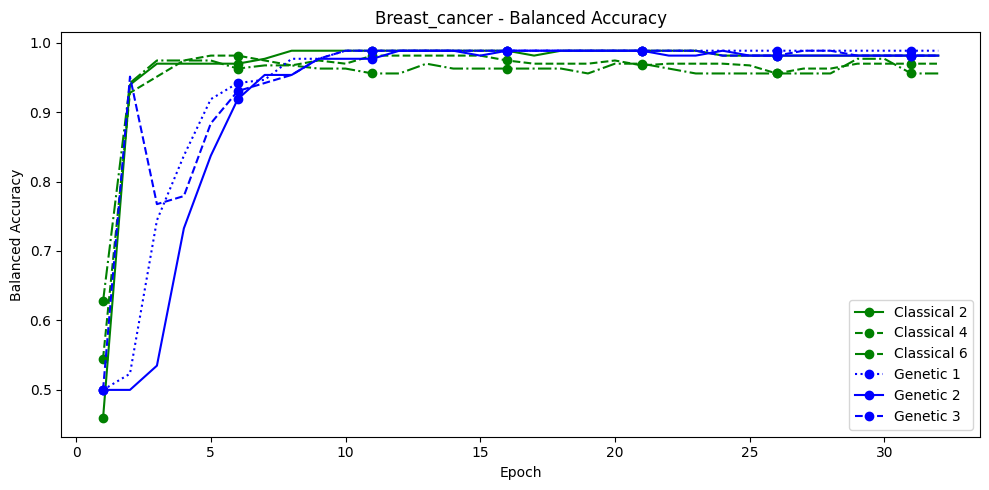

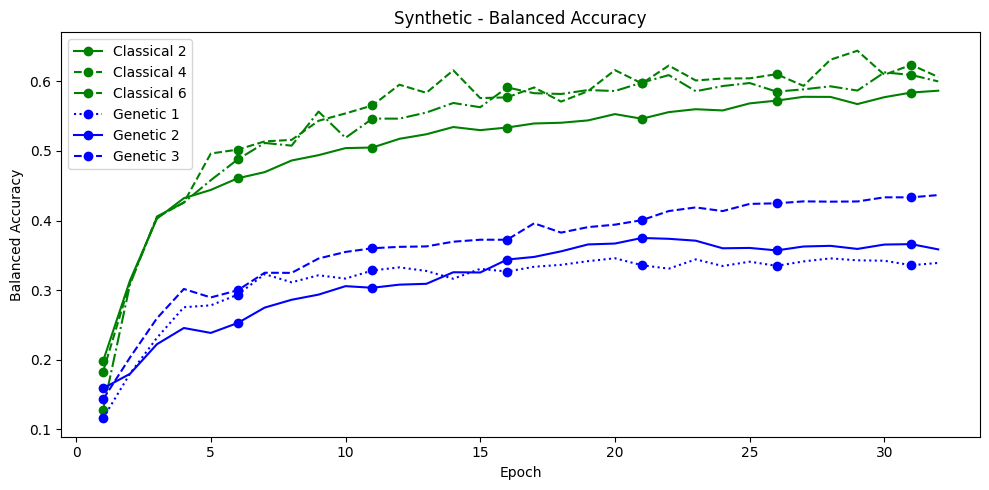

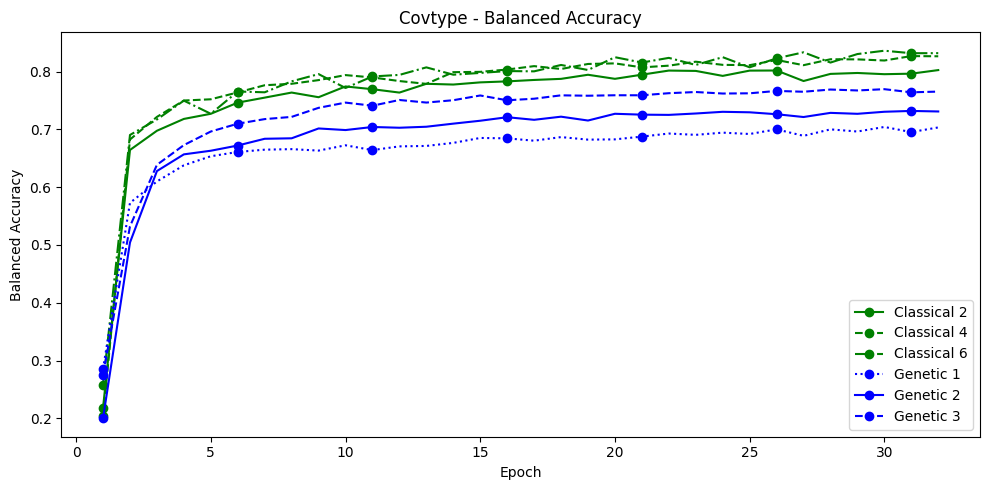

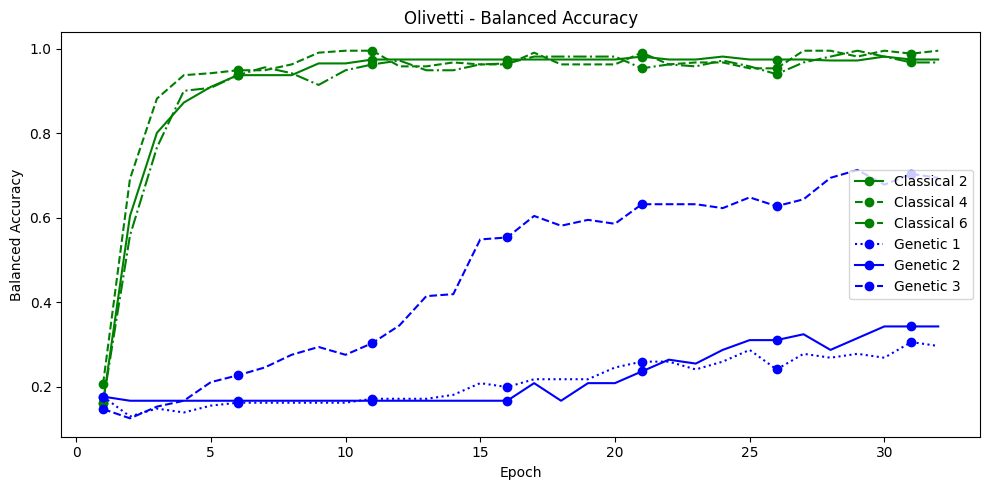

In [6]:
datasets_list = list(processed_datasets.keys())
models = [("classical", depth) for depth in classical_depths] + [
    ("genetic", n_heads) for n_heads in genetic_heads
]

for dataset in datasets_list:
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Balanced Accuracy
    ax.set_title(f"{dataset.capitalize()} - Balanced Accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Balanced Accuracy")

    colors = {"classical": "green", "genetic": "blue"}
    # Different linestyles for each model
    linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":"]
    # Same marker for all to avoid confusion
    markers = ["o"] * len(models)

    for i, (arch, depth) in enumerate(models):
        key = f"{dataset}_{arch}_{depth}"
        metrics = results[key]

        epochs = range(1, len(metrics["train_loss_history"]) + 1)

        color = colors[arch]
        linestyle = linestyles[i]
        marker = markers[i]

        # Plot balanced accuracy
        ax.plot(
            epochs,
            metrics["val_bal_acc_history"][: len(epochs)],
            color=color,
            linestyle=linestyle,
            marker=marker,
            markevery=5,
            label=f"{arch.capitalize()} {depth}",
        )

    ax.legend()

    plt.tight_layout()
    plt.savefig(f"artefacts/genetic_layer_balanced_accuracy_{dataset}.png")
    plt.show()

### 4.1 Balanced Accuracy Over Epochs

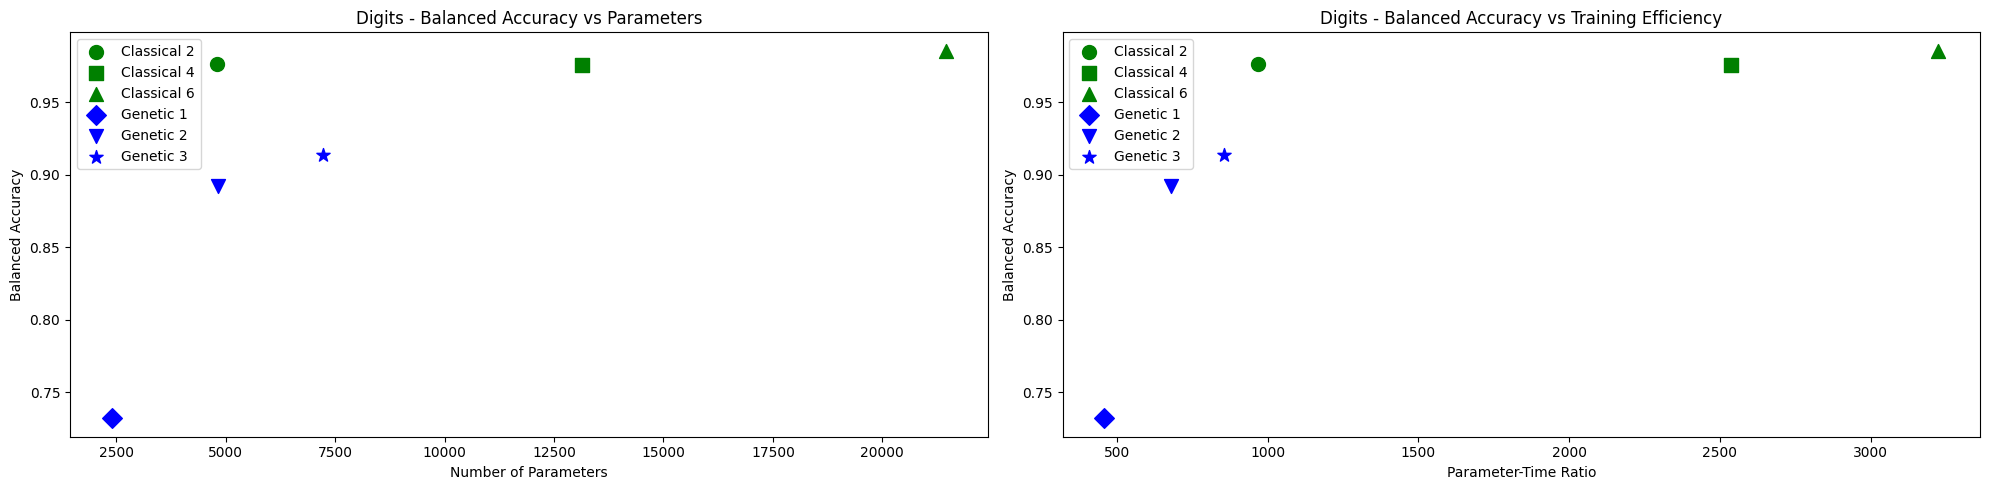

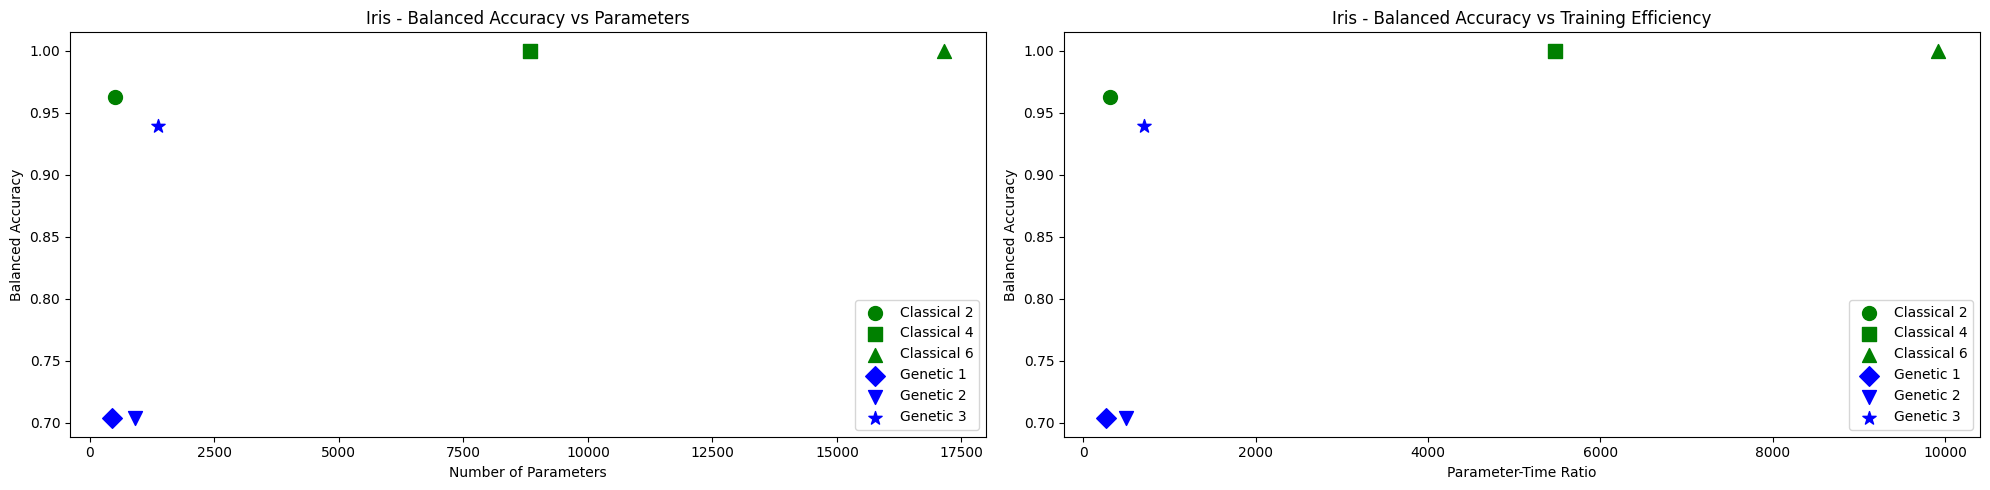

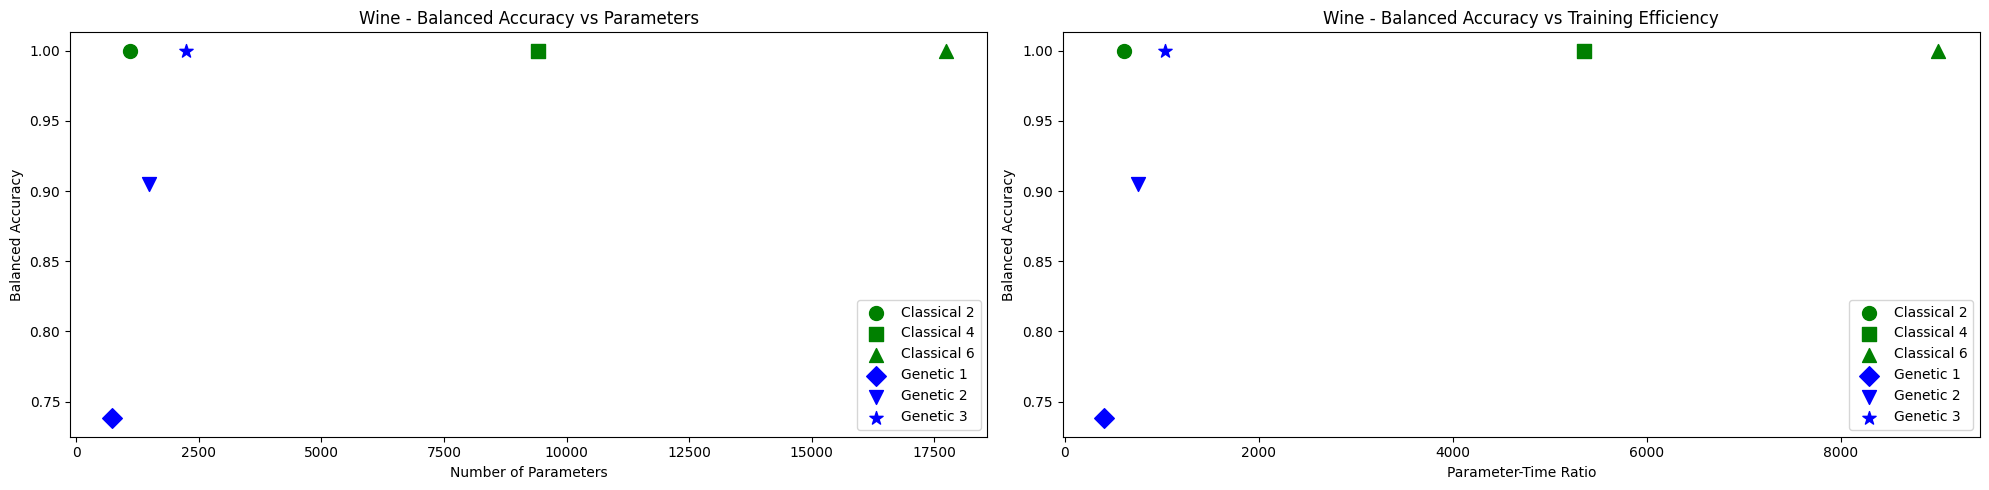

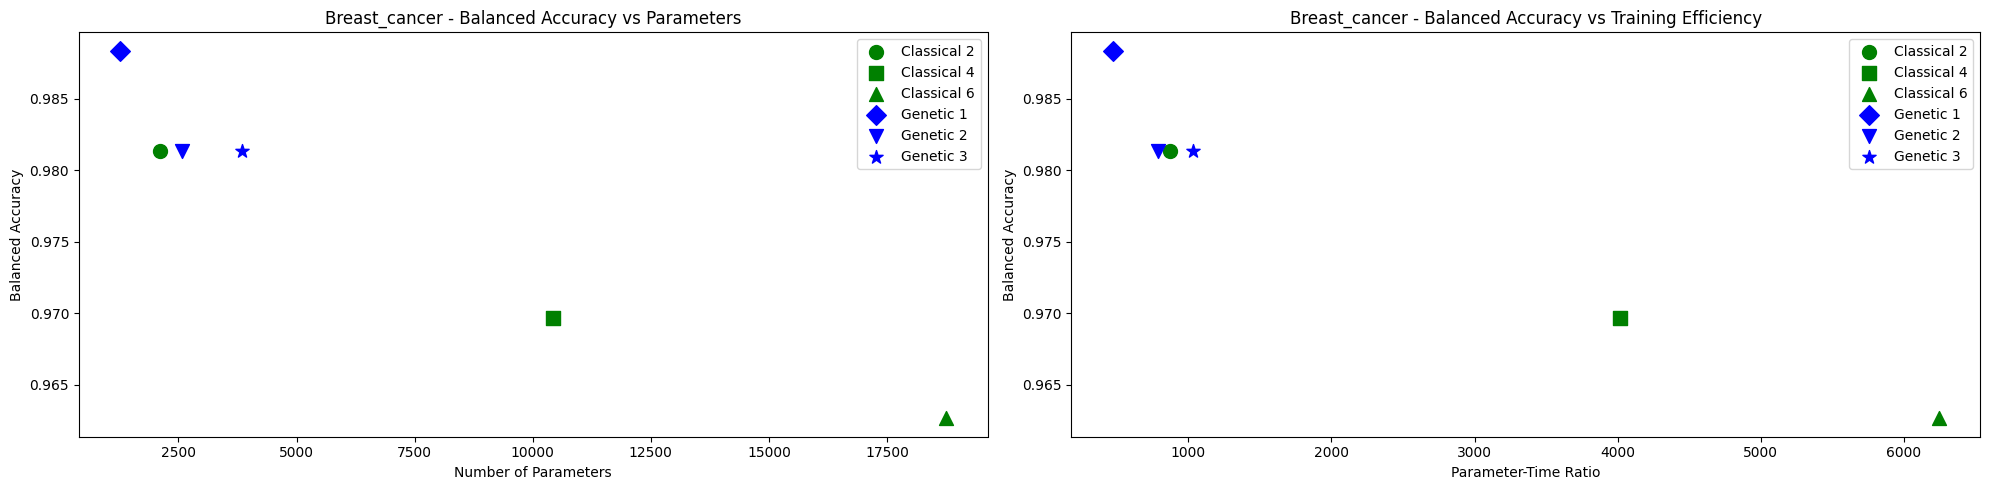

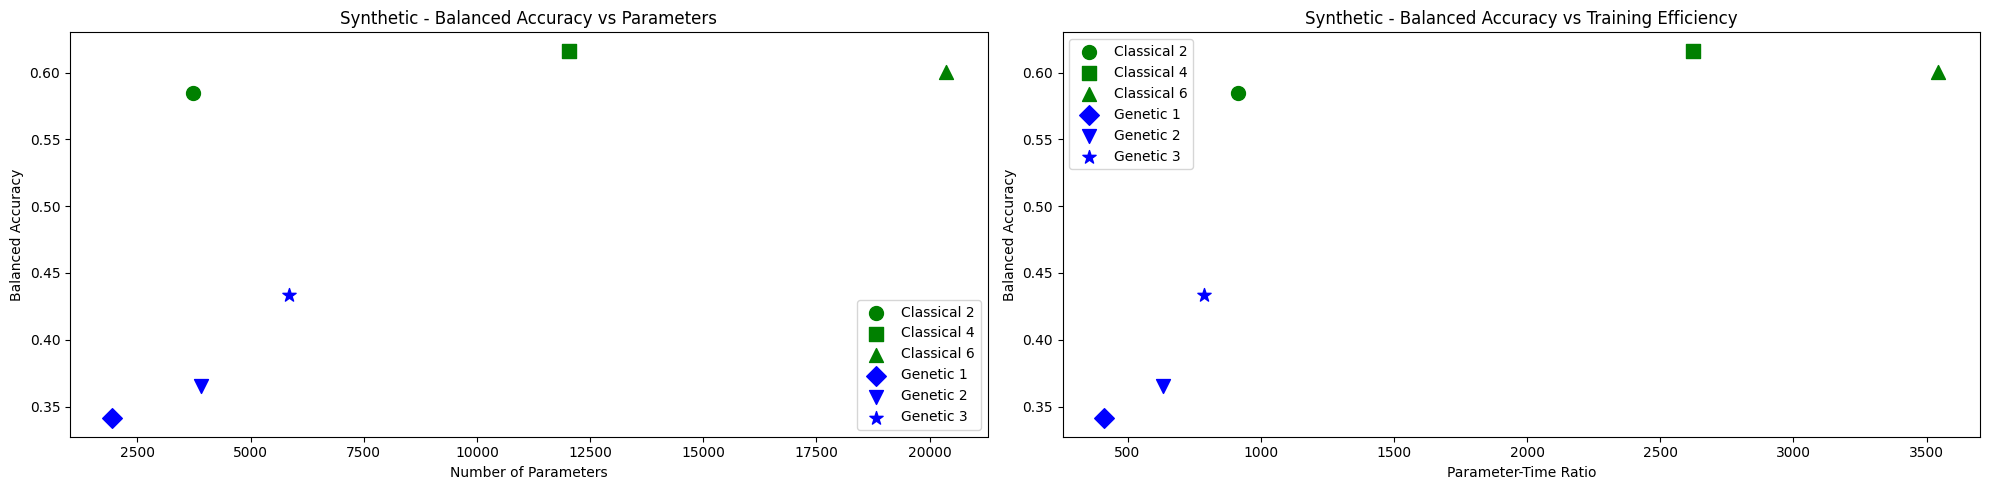

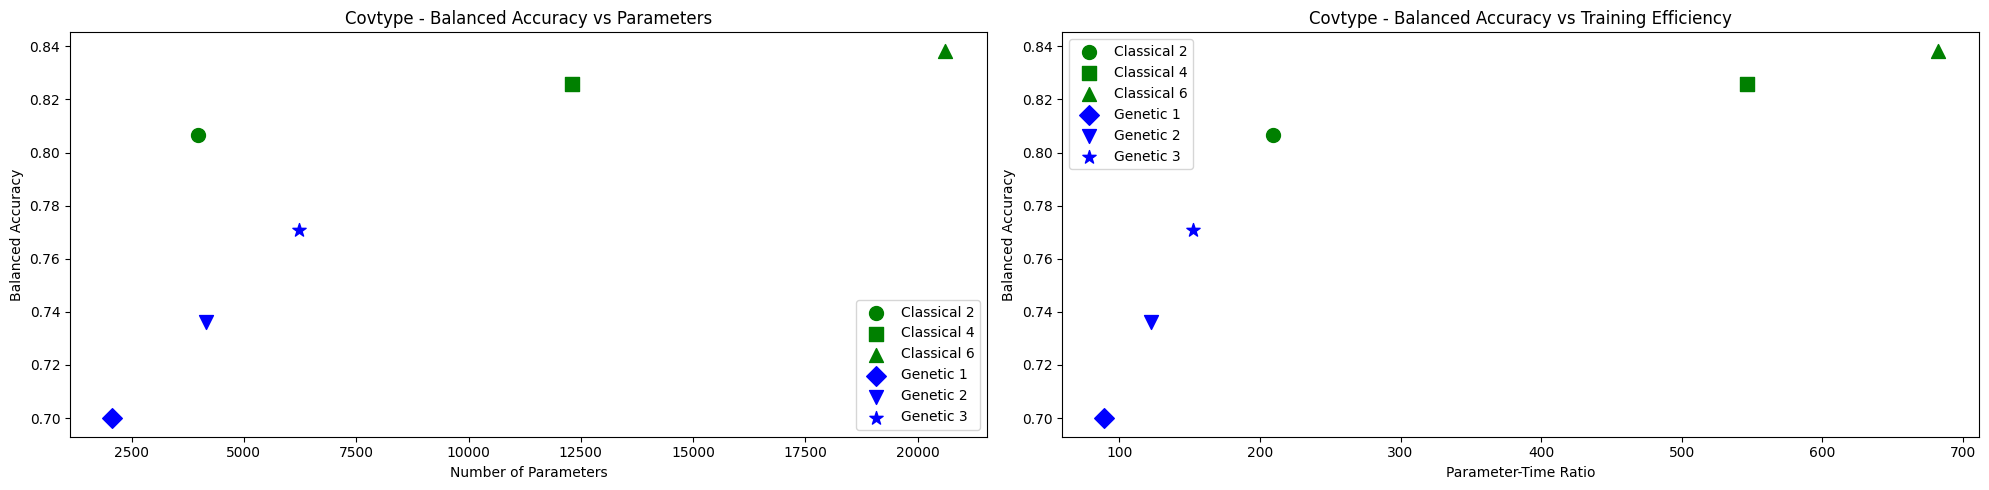

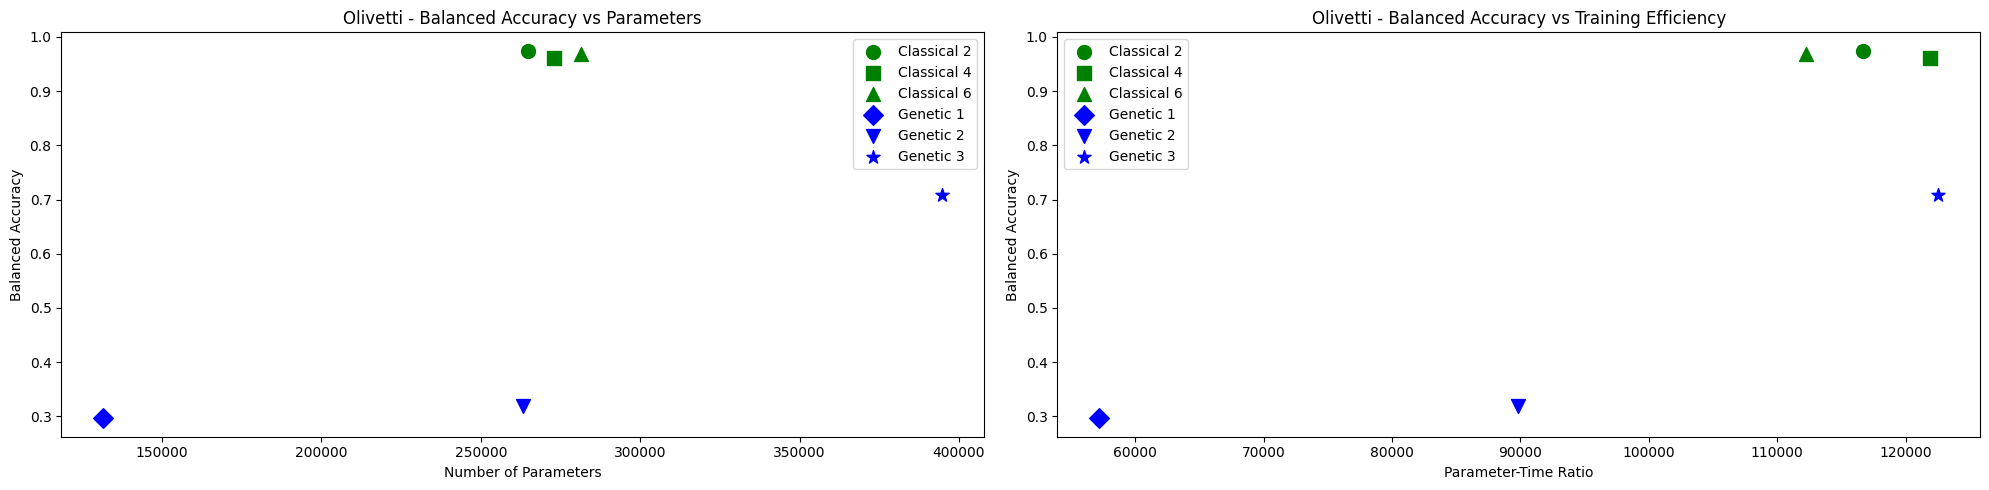

In [7]:
for dataset in datasets_list:
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    # First subplot: Balanced Accuracy vs Number of Parameters
    axes[0].set_title(f"{dataset.capitalize()} - Balanced Accuracy vs Parameters")
    axes[0].set_xlabel("Number of Parameters")
    axes[0].set_ylabel("Balanced Accuracy")

    # Second subplot: Balanced Accuracy vs Parameter-Time Ratio
    axes[1].set_title(
        f"{dataset.capitalize()} - Balanced Accuracy vs Training Efficiency"
    )
    axes[1].set_xlabel("Parameter-Time Ratio")
    axes[1].set_ylabel("Balanced Accuracy")

    colors = {"classical": "green", "genetic": "blue"}
    markers = [
        "o",
        "s",
        "^",
        "D",
        "v",
        "*",
        "p",
        "h",
    ]  # Different markers for each model

    for i, (arch, depth) in enumerate(models):
        key = f"{dataset}_{arch}_{depth}"
        metrics = results[key]

        num_params = metrics["num_params"]
        param_time_ratio = metrics["num_params"] / metrics["training_time"]
        bal_acc = metrics["val_bal_acc_history"][-1]

        color = colors[arch]
        marker = markers[i]

        # Plot vs parameters
        axes[0].scatter(
            num_params,
            bal_acc,
            color=color,
            marker=marker,
            s=100,
            label=f"{arch.capitalize()} {depth}",
        )

        # Plot vs parameter-time ratio
        axes[1].scatter(
            param_time_ratio,
            bal_acc,
            color=color,
            marker=marker,
            s=100,
            label=f"{arch.capitalize()} {depth}",
        )

    axes[0].legend()
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"artefacts/genetic_layer_benchmark_{dataset}.png")
    plt.show()

### 4.2 Performance Analysis

In [8]:
# Summary table of results
summary_data = []
for dataset in datasets_list:
    for arch, depth in models:
        key = f"{dataset}_{arch}_{depth}"
        metrics = results[key]
        summary_data.append(
            {
                "Dataset": dataset.capitalize(),
                "Architecture": arch.capitalize(),
                "Depth": depth,
                "Num_Layers": depth,
                "Num_Params": metrics["num_params"],
                "Training_Time (s)": round(metrics["training_time"], 4),
                "Final_Val_Loss": round(metrics["final_val_loss"], 4),
                "Final_Val_Acc": round(metrics["final_val_acc"], 4),
                "Final_Bal_Acc": round(metrics["val_bal_acc_history"][-1], 4),
                "Param_Time_Ratio": round(
                    metrics["num_params"] / metrics["training_time"], 4
                ),
                "Acc_Param_Efficiency": round(
                    metrics["val_bal_acc_history"][-1] / metrics["num_params"], 4
                ),
                "Avg_Train_Loss": round(
                    sum(metrics["train_loss_history"])
                    / len(metrics["train_loss_history"]),
                    4,
                ),
                "Avg_Val_Loss": round(
                    sum(
                        metrics["val_loss_history"][
                            : len(metrics["train_loss_history"])
                        ]
                    )
                    / len(metrics["train_loss_history"]),
                    4,
                ),
            }
        )

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.drop(
    columns=[
        "Num_Layers",
        "Num_Params",
        "Training_Time (s)",
        "Final_Val_Loss",
        "Final_Val_Acc",
        "Avg_Train_Loss",
        "Avg_Val_Loss",
    ]
)
summary_df = summary_df.set_index(["Dataset", "Architecture", "Depth"])
summary_df = summary_df.sort_index()
columns_order = ["Final_Bal_Acc"] + [
    col for col in summary_df.columns if col != "Final_Bal_Acc"
]
summary_df = summary_df[columns_order]


def highlight_max_per_group(df):
    # Color rows by dataset with dark mode friendly colors
    def color_rows(row):
        dataset = row.name[0]
        colors = {
            "Breast_cancer": "#4C566A",
            "Covtype": "#BF616A",
            "Digits": "#5E81AC",
            "Iris": "#81A1C1",
            "Olivetti": "#D08770",
            "Synthetic": "#88C0D0",
            "Wine": "#8FBCBB",
        }
        color = colors.get(dataset, "#2E3440")
        return [
            f"background-color: {color}; color: #ECEFF4" for _ in row
        ]  # Light text on dark background

    styled = df.style.apply(color_rows, axis=1)

    # Highlight max balanced accuracy per dataset-architecture group
    def highlight(s):
        is_max = s.groupby(level=[0, 1]).transform("max") == s
        return [
            "background-color: #A3BE8C; color: #2E3440" if v else "" for v in is_max
        ]

    return styled.apply(highlight, subset=["Final_Bal_Acc"])


display(highlight_max_per_group(summary_df))

# Save the summary dataframe to disk
summary_df.to_csv("artefacts/genetic_layer_summary.csv")

### 4.3 Summary Table

In [9]:
pd.DataFrame(summary_data)

,Dataset,Architecture,Depth,Num_Layers,Num_Params,Training_Time (s),Final_Val_Loss,Final_Val_Acc,Final_Bal_Acc,Param_Time_Ratio,Acc_Param_Efficiency,Avg_Train_Loss,Avg_Val_Loss
0,Digits,Classical,2,2,4810,4.9612,0.0777,0.9750,0.9760,969.5315,0.0002,0.1898,0.2577
1,Digits,Classical,4,4,13130,5.1744,0.0823,0.9750,0.9756,2537.4727,0.0001,0.1016,0.1984
2,Digits,Classical,6,6,21450,6.6528,0.0902,0.9861,0.9854,3224.1946,0.0000,0.0793,0.1994
3,Digits,Genetic,1,1,2394,5.2210,1.1631,0.7417,0.7322,458.5287,0.0003,1.5717,1.5739
4,Digits,Genetic,2,2,4818,7.0894,0.3670,0.8917,0.8920,679.6035,0.0002,0.9776,0.9995
5,Digits,Genetic,3,3,7222,8.4296,0.3252,0.9139,0.9133,856.7391,0.0001,0.6932,0.7921
6,Iris,Classical,2,2,515,1.6552,0.2366,0.9667,0.9630,311.1465,0.0019,0.5096,0.4740
7,Iris,Classical,4,4,8835,1.6147,0.0441,1.0000,1.0000,5471.6771,0.0001,0.2880,0.2520
8,Iris,Classical,6,6,17155,1.7296,0.0292,1.0000,1.0000,9918.4156,0.0001,0.1963,0.1562
9,Iris,Genetic,1,1,439,1.6691,0.8346,0.7333,0.7037,263.0185,0.0016,0.9900,0.9676
